# LocatNet

#### 0. Libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from random import randrange
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### 1. Data import and manipulation

<ul>
  <li>image_size - desired feature dimensions.</li>
  <li>EPOCHS - number of epochs when training the CNN.</li>
  <li>MAX_IMAGES - amount of image samples.</li>
</ul>

In [2]:
image_size = (200, 200)
EPOCHS = 100
MAX_IMAGES = 12000
IMAGE_COUNT = 0                     # is set later

Preprocess data to feature and label space.

In [3]:
def load_images_and_labels(image_folder, country_counts, labels_df, max_images = IMAGE_COUNT):
    images = []
    labels = []

    excluded_images_count = 0

    for index, row in labels_df.iterrows():
        if len(images) >= max_images:
            break

        currentCountry = row['country']
        count = country_counts.loc[country_counts['country'] == currentCountry].values[0]

        if count[1] > 150:                              # make sure there are at least 20 samples of every label
            img_path = os.path.join(image_folder, str(row['ID']) + '.png')
            print(f"\rProcessing {str(row['ID'])}.png", flush=True, end='')

            img = cv2.imread(img_path)                  # load current image
            img = cv2.resize(img, image_size)           # resize
            img = img / 255.0                           # normalization

            images.append(img)
            labels.append(row['country'])
        else:                                       # skip low sample count labels
            excluded_images_count += 1
    
    print(f'\r{excluded_images_count} images were excluded due to low sample count.', flush=True)
    print(f'{len(images)} images were loaded.')
    return np.array(images), np.array(labels)       # sample + label array

Retrieve the data using the function.

In [4]:
image_folder = 'Data'
labels_df = pd.read_csv('coordinates_with_country.csv')
country_counts = pd.read_csv('country_counts.csv')

IMAGE_COUNT = labels_df.shape[0]                        # set the default image count

In [5]:
X, y = load_images_and_labels(image_folder, country_counts, labels_df, MAX_IMAGES)

1248 images were excluded due to low sample number.
12000 images were loaded.


In [6]:
def convert_to_uint8(image):
    # If the image is in float64 (CV_64F), we need to normalize and convert it to uint8
    if image.dtype == np.float64:
        image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)
    return image

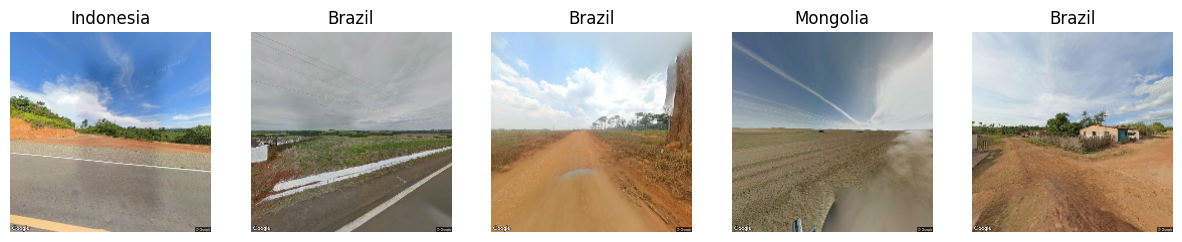

In [7]:
random_indices = random.sample(range(X.shape[0]), 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Iterate over the selected indices and plot each image
for i, idx in enumerate(random_indices):
    img = X[idx]
    img = convert_to_uint8(img)
    
    # Convert image from BGR (OpenCV default) to RGB for correct color display in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    axs[i].imshow(img_rgb)
    axs[i].axis('off')  # Hide the axes

    axs[i].set_title(f'{y[idx]}', fontsize=12)

plt.show()

Encode the labels <span style="color:green"><b>(country names)</b></span> into numbers.

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Check dimensions of the data.

In [9]:
print(f"Number of samples: {X.shape[0]}")
print(f"Dimension of image samples: {X.shape[1:3]}")
print(f"Color channels in the image samples: {X.shape[3]}")

Number of samples: 12000
Dimension of image samples: (200, 200)
Color channels in the image samples: 3


Train-Test split.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

#### 2. Definition of the CNN

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y_encoded)), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

c:\Users\orddi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,886,315 (7.20 MB)

 Trainable params: 1,885,611 (7.19 MB)

 Non-trainable params: 704 (2.75 KB)

#### 3. Data augmentation <font color='#66FF07'><b>(Optional)</b></font>

In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

#### 4. Training and Evaluation

Fitting the model

##### <font color='red'><b>WITHOUT</b></font> data augmentation

In [ ]:
history = model.fit(X_train, y_train, batch_size=32,
                    epochs=EPOCHS, validation_data=(X_test, y_test))

##### <font color='#66FF07'><b>WITH</b></font> data augmentation

In [15]:
# Use the augmented data during training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val))

c:\Users\orddi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 142s 582ms/step - accuracy: 0.1548 - loss: 3.7313 - val_accuracy: 0.1536 - val_loss: 3.9822
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 131s 544ms/step - accuracy: 0.2417 - loss: 2.7875 - val_accuracy: 0.1932 - val_loss: 2.9491
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 129s 537ms/step - accuracy: 0.2621 - loss: 2.6073 - val_accuracy: 0.2531 - val_loss: 2.6645
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 0.2757 - loss: 2.5637 - val_accuracy: 0.1479 - val_loss: 5.3242
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 129s 537ms/step - accuracy: 0.2786 - loss: 2.5558 - val_accuracy: 0.2625 - val_loss: 2.7247
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 129s 536ms/step - accuracy: 0.2879 - loss: 2.4531 - val_accuracy: 0.2526 - val_loss: 2.9779
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 130s 539ms/step - accuracy: 0.3055 - loss: 2.4018 - val_accuracy: 0.1094 - val_loss: 4.4932
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 

#### 5. Testing

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.4822 - loss: 2.4194
Test accuracy: 0.48500001430511475


Accuracy and Loss to Epochs graphs

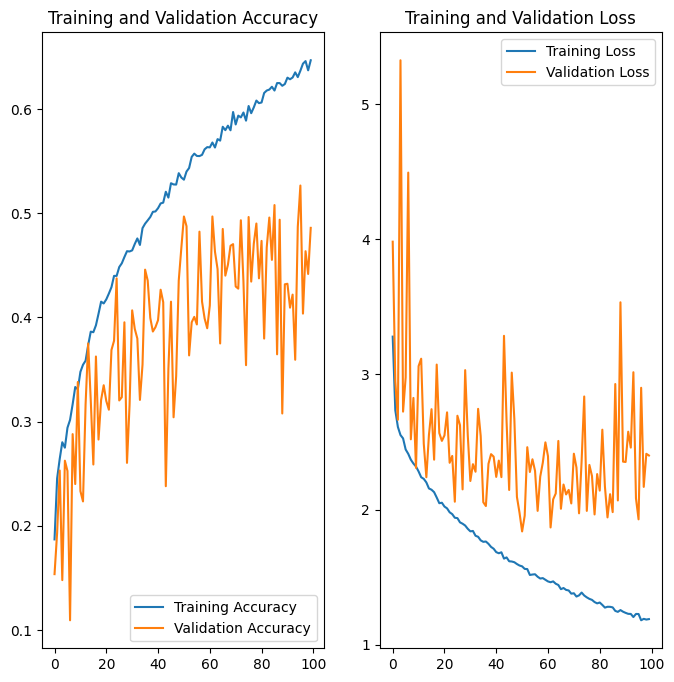

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving the model

In [18]:
model.save('models/locatNet.keras')

FileNotFoundError: [Errno 2] No such file or directory: 'models/locatNet.keras'

In [ ]:
model = load_model('locatNet.keras')

#### Issue a report on the model

In [39]:
def record_results(model, history, test_acc):
    insight_dir = "Reports"
    os.makedirs(insight_dir, exist_ok=True)

    hyperparams = {
        "image_size": image_size,
        "epochs": EPOCHS,
        "batch_size": 32,
        "max_images": MAX_IMAGES,
        "optimizer": "adam",
        "loss_function": "categorical_crossentropy",
    }

    run_name = f"{len(history.history['accuracy'])}Epochs_{hyperparams['max_images']}"
    run_dir = os.path.join(insight_dir, run_name)
    os.makedirs(run_dir, exist_ok=True)

    # Save hyperparameters to a text file
    with open(os.path.join(run_dir, "hyperparameters.txt"), "w", encoding='utf-8') as f:
        for key, value in hyperparams.items():
            f.write(f"{key}: {value}\n")

    # Save model summary
    with open(os.path.join(run_dir, "model_summary.txt"), "w", encoding='utf-8') as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))

    with open(os.path.join(run_dir, "model_results.txt"), "w", encoding='utf-8') as f:
        f.write(f"Test accuracy: {test_acc}\n\n")
        for index in range(len(history.history['accuracy'])):
            f.write(f"## Epoch {index + 1} ##\n")
            f.write(f"  Training accuracy: {history.history['accuracy'][index]:.4f}\n")
            f.write(f"      Training loss: {history.history['loss'][index]:.4f}\n")
            f.write(f"          Validation accuracy: {history.history['val_accuracy'][index]:.4f}\n")
            f.write(f"              Validation loss: {history.history['val_loss'][index]:.4f}\n\n")
    
    print(f"Report created at {run_dir}")

In [ ]:
record_results(model, history, test_acc)

Visualization

In [59]:
def visualize_activations(model, image, layer_names, image_size):
    
    res = model(image)

    activation_model = Model(inputs=model.input, outputs=layer_names)

    img_resized = tf.image.resize(image, (image_size, image_size))
    img_resized = tf.expand_dims(img_resized, axis=0)

    # Pass the image through the model to get activations
    activations = activation_model.predict(img_resized)

    # Plot activations for each convolutional layer
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]  # Number of features (channels) in the activation map
        size = layer_activation.shape[1]  # Spatial dimensions of the activation map

        # Set up a grid for plotting
        cols = 8  # Number of columns to display
        rows = n_features // cols if n_features >= cols else 1

        print(f"Visualizing Activations for Layer: {layer_name}")
        fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
        axes = axes.flatten()  # Flatten axes array for easy indexing

        # Plot each activation map
        for i in range(n_features):
            if i < len(axes):
                ax = axes[i]
                ax.imshow(layer_activation[0, :, :, i], cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Filter {i+1}')

        plt.tight_layout()
        plt.show()

In [ ]:
random_index = random.sample(range(len(X_test)), 1)[0]
test_image = X_test[random_index]
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
visualize_activations(model, test_image, conv_layers, image_size)